# Creating and excecuting MDF models

This is a quick introduction to building MDF graphs and using them in different scenarios.

1. **[Create a Model containing a Graph](#h1)**
2. **[Generate a graph image from the model](#h2)**
3. **[Execute the graph & print the output values](#h3)**


## 1. Create a [Model](https://mdf.readthedocs.io/en/latest/api/Specification.html#model) containing a [Graph](https://mdf.readthedocs.io/en/latest/api/Specification.html#graph) <a class="anchor" id="h1"></a>


In [3]:
from modeci_mdf.mdf import *

# Create a model containing one graph
mod = Model(id="AB")
mod_graph = Graph(id="ab_example")
mod.graphs.append(mod_graph)



### 1.1 Create the first [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [4]:
# Create a node
a_node = Node(id="A", metadata={"color": "0 .8 0"})

# Add a parameter with a specific value
a_node.parameters.append(Parameter(id="level", value=1.0))

# Add an output port
a_node.output_ports.append(OutputPort(id="output", value = "level"))

# Add node to the graph
mod_graph.nodes.append(a_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level



### 1.2 Create another [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [5]:
b_node = Node(id="B", metadata={"color": ".8 0 0"})
mod_graph.nodes.append(b_node)

# Add an input port
b_node.input_ports.append(InputPort(id="input"))

# Add some parameters
b_node.parameters.append(Parameter(id="slope", value=1.2))
b_node.parameters.append(Parameter(id="intercept", value=3))


# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="linear_func",
    value="input * slope + intercept",
)
b_node.parameters.append(p1)

# Add an output port
b_node.output_ports.append(OutputPort(id="output", value="linear_func"))


### 1.3 Create an  [Edge](https://mdf.readthedocs.io/en/latest/api/Specification.html#edge) between the [Nodes](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [6]:
# This helper method just adds an edge connecting the first output port of 
# the pre node to the first input port of the post node
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)

# Print the current structure
print(mod_graph.to_yaml())


ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                slope:
                    value: 1.2
                intercept:
                    value: 3
                linear_func:
                    value: input * slope + intercept
            output_ports:
                output:
                    value: linear_func
    edges:
        edge_A_B:
            sender: A
            receiver: B
            sender_port: output
            receiver_port: input



### 1.4 Save the model to file

The model can be saved to a file (serialized) in either JSON or YAML format.

In [7]:
mod.to_json_file("AB.json")
mod.to_yaml_file("AB.yaml")

'AB.yaml'

## 2. Generate a graph image from the model <a class="anchor" id="h2"></a>

We will use a method on the model to generate an image representing the structure of the graph.


Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
Checking whether Parameter(metadata=None, id='linear_func', value='input * slope + intercept', default_initial_value=None, time_derivative=None, function=None, args=None, conditions=[]) is stateful, {intercept, input, slope}: False
    Edge: edge_A_B connects A to B
Written graph image to: AB.png


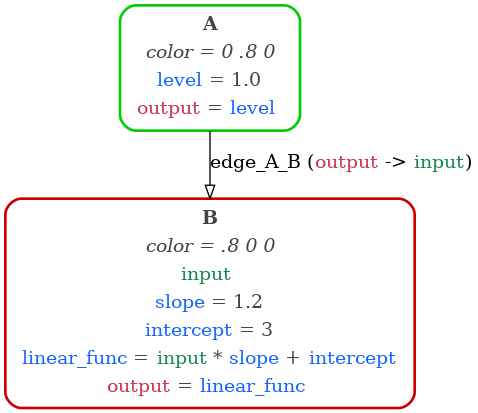

In [8]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB"
    )

from IPython.display import Image
Image(filename="AB.png")

## 3. Execute the graph & print the output values <a class="anchor" id="h3"></a>

The Graph is converted to an EvaluableGraph, which can be used to evaluate the current state of the graph's parameters. 

### 3.1 Execute the graph with the current parameter values 

In [9]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)


Init graph: ab_example
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Checking whether Parameter(metadata=None, id='linear_func', value='input * slope + intercept', default_initial_value=None, time_derivative=None, function=None, args=None, conditions=[]) is stateful, {intercept, input, slope}: False
Output of A: 1
Output of B: 4.2


### 3.2 Change a value to a Numpy array & execute the graph again

In [10]:
import numpy as np 
a_node.get_parameter('level').value = np.array([[1,2],[3,4]])

eg.evaluate()

print('Output of A:\n%s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B:\n%s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)

Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.2 5.4]
 [6.6 7.8]]


Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
Checking whether Parameter(metadata=None, id='linear_func', value='input * slope + intercept', default_initial_value=None, time_derivative=None, function=None, args=None, conditions=[]) is stateful, {intercept, input, slope}: False
    Edge: edge_A_B connects A to B
Written graph image to: states.png


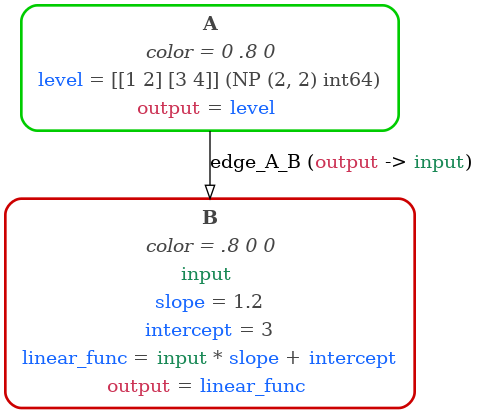

In [11]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="states"
    )

from IPython.display import Image
Image(filename="states.png")

## 4. Adding state variable to node B of the existing graph

### 4.1 Adding state variable named 'rate' to node B where time derivative is rate

In [12]:
s2 = Parameter(
        id="rate",
        default_initial_value=1,
        time_derivative="rate",
    )
b_node.parameters.append(s2)

op1 = OutputPort(id="output", value="rate * linear_func")
b_node.output_ports[-1] = op1

### 4.2 Displaying the modified graph

Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
Checking whether Parameter(metadata=None, id='linear_func', value='input * slope + intercept', default_initial_value=None, time_derivative=None, function=None, args=None, conditions=[]) is stateful, {intercept, input, slope}: False
    Edge: edge_A_B connects A to B
Written graph image to: AB.png


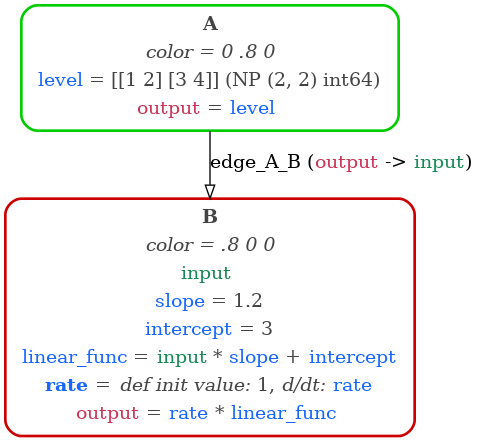

In [13]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB"
    )

from IPython.display import Image
Image(filename="AB.png")

### 4.3 The Graph is converted to an EvaluableGraph,to evaluate the current state of the graph's parameters. 

In [14]:
duration = 2
dt = 0.01
t = 0
times = []
eg = EvaluableGraph(mod_graph, verbose=False)
while t <= duration:
    times.append(t)
    print("======   Evaluating at t = %s  ======" % (t))
    if t == 0:
        eg.evaluate()
    else:
        eg.evaluate(time_increment=dt)

    print('Output of A:\n%s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
    print('Output of B:\n%s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)
    t += dt



Init graph: ab_example
======   Evaluating at t = 0  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Checking whether Parameter(metadata=None, id='linear_func', value='input * slope + intercept', default_initial_value=None, time_derivative=None, function=None, args=None, conditions=[]) is stateful, {intercept, input, slope}: False
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.2 5.4]
 [6.6 7.8]]
======   Evaluating at t = 0.01  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.242 5.454]
 [6.666 7.878]]
======   Evaluating at t = 0.02  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.28442 5.50854]
 [6.73266 7.95678]]
======   Evaluating at t = 0.03  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.3272642 5.5636254]
 [6.7999866 8.0

Output of A:
[[1 2]
 [3 4]]
Output of B:
[[15.61962596 20.08237623]
 [24.54512651 29.00787678]]
======   Evaluating at t = 1.330000000000001  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[15.77582222 20.2832    ]
 [24.79057777 29.29795555]]
======   Evaluating at t = 1.340000000000001  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[15.93358044 20.486032  ]
 [25.03848355 29.59093511]]
======   Evaluating at t = 1.350000000000001  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[16.09291625 20.69089232]
 [25.28886839 29.88684446]]
======   Evaluating at t = 1.360000000000001  ======
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[16.25384541 20.89780124]
 [25.54175707 30.1857129 ]]
======   Evaluat